# Machine Learning GridSearch Pipeline

In [65]:
# Import libraries
import os
import sys

# cpu_count returns the number of CPUs in the system.
from multiprocessing import cpu_count

import numpy as np
import pandas as pd

# Import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Import preprocessing methods from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

# Import PCA
from sklearn.decomposition import PCA

# Import feature_selection tools
from sklearn.feature_selection import VarianceThreshold
#from sklearn.feature_selection import RFE
#from sklearn.feature_selection import RFECV

# Import models from sklearn
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Import XGBClassifier
from xgboost.sklearn import XGBClassifier

# Import from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Modify notebook settings
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150
%matplotlib inline
plt.style.use('ggplot')

### Create paths to data file, append `src` directory to sys.path

In [3]:
# Create a variable for the project root directory
proj_root = os.path.join(os.pardir)

# Save path to the processed data file
# "dataset_processed.csv"
processed_data_file = os.path.join(proj_root,
                                   "data",
                                   "processed",
                                   "dataset_processed.csv")

In [4]:
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(proj_root, "src")
sys.path.append(src_dir)

### Read in the processed data

In [5]:
# Read in the processed credit card client default data set.
df = pd.read_csv(processed_data_file, 
                           index_col=0)

df.head()

,y,limit_bal,age,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,bl_ratio_1,bl_ratio_2,bl_ratio_3,bl_ratio_4,bl_ratio_5,bl_ratio_6,blpl_ratio_1,blpl_ratio_2,blpl_ratio_3,blpl_ratio_4,blpl_ratio_5,blpl_ratio_6,sex_2,edu_2,edu_3,edu_4,marriage_1,marriage_2,marriage_3,pay_1_-2,pay_1_0,pay_1_1,pay_1_2,pay_1_3,pay_1_4,pay_1_5,pay_1_6,pay_1_7,pay_1_8,pay_2_-2,pay_2_0,pay_2_1,pay_2_2,pay_2_3,pay_2_4,pay_2_5,pay_2_6,pay_2_7,pay_2_8,pay_3_-2,pay_3_0,pay_3_1,pay_3_2,pay_3_3,pay_3_4,pay_3_5,pay_3_6,pay_3_7,pay_3_8,pay_4_-2,pay_4_0,pay_4_1,pay_4_2,pay_4_3,pay_4_4,pay_4_5,pay_4_6,pay_4_7,pay_4_8,pay_5_-2,pay_5_0,pay_5_2,pay_5_3,pay_5_4,pay_5_5,pay_5_6,pay_5_7,pay_5_8,pay_6_-2,pay_6_0,pay_6_2,pay_6_3,pay_6_4,pay_6_5,pay_6_6,pay_6_7,pay_6_8
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,20000,24,3913,3102,689,0,0,0,0,689,0,0,0,0,0.195650,0.155100,0.034450,0.000000,0.000000,0.000000,0.195650,0.120650,0.034450,0.000000,0.000000,0.000000,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0.022350,0.014375,0.022350,0.027267,0.028792,0.027175,0.022350,0.006042,0.014017,0.018933,0.028792,0.010508,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0.324878,0.155856,0.150656,0.159233,0.166089,0.172767,0.308011,0.139189,0.139544,0.148122,0.154978,0.117211,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0.939800,0.964660,0.985820,0.566280,0.579180,0.590940,0.899800,0.924280,0.961820,0.544280,0.557800,0.570940,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0.172340,0.113400,0.716700,0.418800,0.382920,0.382620,0.132340,-0.620220,0.516700,0.238800,0.369140,0.369040,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


### Train test split

In [6]:
# Extract X and y from df
X = df.drop('y', axis=1).values
#y = df[['y']].values
y = df['y'].values

# Train test split
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
# Define a function`namestr` to access the name of a variable
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj][0]

In [8]:
# Print the shape of X, y, X_train, X_test, y_train, and y_test
for var in [X, y, X_train, X_test, y_train, y_test]:
    print(namestr(var, globals()), 
          'shape:\t',
          var.shape)

X shape:	 (30000, 91)
y shape:	 (30000,)
X_train shape:	 (20100, 91)
X_test shape:	 (9900, 91)
y_train shape:	 (20100,)
y_test shape:	 (9900,)


### Make pipeline

In [9]:
df_X = df.drop('y', axis=1)

In [10]:
def create_binary_feature_list(df=df_X,  
                               return_binary_features=True):
    """
    Docstring ...
    """
    # Create boolean maskDrop the column with the target values
    binary_mask = df.isin([0, 1]).all()
    
    # If return_binary_features=True,
    # create a list of the binary features.
    # If return_binary_features=False,
    # create a list of the nonbinary features.    
    features_list = list(binary_mask[binary_mask == \
                                     return_binary_features].index)

    return features_list

In [11]:
def binary_feature_index_list(df=df_X, 
                              features_list=None):
    """
    Docstring ...
    """
    
    feature_index_list = [df.columns.get_loc(c) for c  \
                          in df.columns if c in features_list]    
    
    return feature_index_list

In [12]:
binary_features = create_binary_feature_list(df=df_X, 
                                             return_binary_features=True)

non_binary_features = create_binary_feature_list(df=df_X,  
                                                 return_binary_features=False)

binary_index_list = \
    binary_feature_index_list(df=df_X, 
                              features_list=binary_features)

non_binary_index_list = \
    binary_feature_index_list(df=df_X, 
                              features_list=non_binary_features)

In [13]:
print('Binary features:\n')
print(''.join('{:2s}: {:40s}'.format(str(i), col) \
              for i, col in zip(binary_index_list,
                                binary_features)))
print('\n')

print('Non-binary features:\n')
print(''.join('{:2s}: {:40s}'.format(str(i), col) \
              for i, col in zip(non_binary_index_list,
                                non_binary_features)))

Binary features:

26: sex_2                                   27: edu_2                                   28: edu_3                                   29: edu_4                                   30: marriage_1                              31: marriage_2                              32: marriage_3                              33: pay_1_-2                                34: pay_1_0                                 35: pay_1_1                                 36: pay_1_2                                 37: pay_1_3                                 38: pay_1_4                                 39: pay_1_5                                 40: pay_1_6                                 41: pay_1_7                                 42: pay_1_8                                 43: pay_2_-2                                44: pay_2_0                                 45: pay_2_1                                 46: pay_2_2                                 47: pay_2_3                                 48: pay_2_4   

#### User defined preprocessors

In [14]:
class NonBinary_PCA(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = PCA(n_components=None, random_state=42)

    # Fit PCA only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with PCA
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [15]:
class NonBinary_RobustScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = RobustScaler()

    # Fit RobustScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with RobustScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [16]:
class NonBinary_StandardScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = StandardScaler()

    # Fit StandardScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with StandardScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

In [17]:
class NonBinary_MinMaxScaler(BaseEstimator, TransformerMixin): 
    def __init__(self):
        self.scaler = MinMaxScaler()

    # Fit MinMaxScaler only on the non-binary features
    def fit(self, X, y):
        self.scaler.fit(X[:, non_binary_index_list], y)
        return self

    # Transform only the non-binary features with MinMaxScaler
    def transform(self, X):
        X_non_binary = \
            self.scaler.transform(X[:, non_binary_index_list])

        X_recombined = X_non_binary

        binary_index_list.sort()
        for col in binary_index_list:
            X_recombined = np.insert(X_recombined, 
                                     col,
                                     X[:, col], 
                                     1)
        return X_recombined

#### Define the pipeline

In [18]:
# Set a high threshold for removing near-zero variance features
thresh_prob = 0.999
threshold = (thresh_prob * (1 - thresh_prob))

# Create pipeline
pipe = Pipeline([('preprocessing_1', VarianceThreshold(threshold)), 
                 ('preprocessing_2', None), 
                 ('preprocessing_3', None), 
                 ('classifier', DummyClassifier(strategy='most_frequent',
                                                random_state=42))])

# Create parameter grid
param_grid = [
    {'classifier': [LogisticRegression(random_state=42)],
     'preprocessing_1': [None], # [VarianceThreshold(threshold)], 
     'preprocessing_2': [NonBinary_RobustScaler()],
     'preprocessing_3': [None, NonBinary_PCA()],
     'classifier__C': [0.01, 0.1],
     'classifier__penalty': ['l1','l2']},

    
    {'classifier': [XGBClassifier(objective='binary:logistic', n_estimators=1000)], 
     'preprocessing_1': [VarianceThreshold(threshold)], 
     'preprocessing_2': [None],
     'preprocessing_3': [None],
     'classifier__n_estimators': [1000],
     'classifier__learning_rate': [0.01, 0.1],
     'classifier__gamma': [0.01, 0.1],
     'classifier__max_depth': [3, 4],
     'classifier__min_child_weight': [1, 3],
     'classifier__subsample': [0.8],
#     'classifier__colsample_bytree': [0.8, 1.0],
     'classifier__reg_lambda': [0.1, 1.0],
     'classifier__reg_alpha': [0, 0.1]}]


In [19]:
# Set the number of cores to be used
cores_used = cpu_count() - 1
cores_used
#cores_used = 1

3

In [ ]:
# Set verbosity
verbosity = 1

# Execute Grid search
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc',
                    verbose=verbosity, n_jobs=cores_used)

grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))

#### Save the grid search object as a pickle file

In [31]:
# Save path to the `models` folder
models_folder = os.path.join(proj_root,
                                   "models")

In [33]:
# full_gridsearch_file_name = 'gridsearch_pickle_20171029.pkl'
full_gridsearch_file_name = 'gridsearch_pickle_20171029.pkl'

full_gridsearch_path = os.path.join(models_folder,
                                    full_gridsearch_file_name)

joblib.dump(grid, full_gridsearch_path)

['../models/gridsearch_pickle_20171029.pkl']

In [34]:
# best_pipeline_file_name = 'pipeline_pickle_20171029.pkl'
best_pipeline_file_name = 'pipeline_pickle_20171029.pkl'

best_pipeline_path = os.path.join(models_folder, 
                                  best_pipeline_file_name)

joblib.dump(grid.best_estimator_, best_pipeline_path)

['../models/pipeline_pickle_20171029.pkl']

#### Read in the best pipeline

In [37]:
clf = joblib.load(best_pipeline_path) 

#### Check AUC scores

In [ ]:
cross_val_results = cross_val_score(clf, 
                                    X_train,
                                    y_train,
                                    scoring="roc_auc", 
                                    cv=5, 
                                    n_jobs=1)

In [91]:
results_mean = np.mean(cross_val_results)

print("Mean Cross validation AUC:\n{}\n".format(results_mean))

Mean Cross validation AUC:
0.785979277708851



In [69]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing_1', VarianceThreshold(threshold=0.000999000000000001)), ('preprocessing_2', None), ('preprocessing_3', None), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))])

In [85]:
auc_train = roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])

print("Train AUC:\n{}\n".format(auc_train))

Train AUC:
0.8319049477240587



In [86]:
auc_test = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print("Train AUC:\n{}\n".format(auc_test))

Train AUC:
0.7833165821084949



#### Plot the Receiver Operating Characteristic Curves

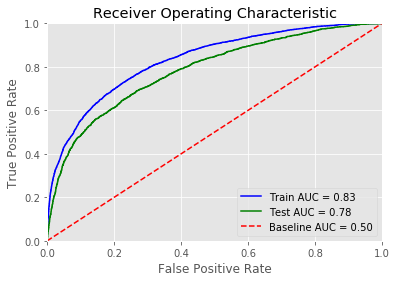

In [90]:
probs = clf.predict_proba(X_train)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_train, preds)
plt.plot(fpr, tpr, 'b', label = 'Train AUC = %0.2f' % roc_auc)

probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
#roc_auc = auc(fpr, tpr)
roc_auc = roc_auc_score(y_test, preds)
plt.plot(fpr, tpr, 'g', label = 'Test AUC = %0.2f' % roc_auc)


plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--',  label = 'Baseline AUC = 0.50' )
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### Check accuracy scores

In [99]:
cross_val_accuracy = cross_val_score(clf, 
                                    X_train,
                                    y_train,
                                    scoring="accuracy", 
                                    cv=5, 
                                    n_jobs=1, 
                                    verbose=1)

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.3min finished


In [100]:
accuracy_mean = np.mean(cross_val_accuracy)

print("Mean Cross validation accuracy:\n{}\n".format(accuracy_mean))

Mean Cross validation accurcy:
0.819850304118473



In [101]:
dummy_clf = DummyClassifier(strategy='most_frequent',
                                    random_state=42)

In [102]:
dummy_cross_val_accuracy = cross_val_score(dummy_clf, 
                                          X_train,
                                          y_train,
                                          scoring="accuracy", 
                                          cv=5, 
                                          n_jobs=1)

In [103]:
dummy_accuracy_mean = np.mean(dummy_cross_val_accuracy)

print("Baseline accuracy:\n{}\n".format(dummy_accuracy_mean))

Baseline accuracy:
0.7772139440726131



### Save the trained model object as a pickle file

In [104]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessing_1', VarianceThreshold(threshold=0.000999000000000001)), ('preprocessing_2', None), ('preprocessing_3', None), ('classifier', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.01, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=nan, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=1.0,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.8))])

In [105]:
# trained_model = 'trained_model_20171029.pkl'
trained_model = 'trained_model_20171029.pkl'

trained_model_path = os.path.join(models_folder,
                                  trained_model)

joblib.dump(grid, trained_model_path)

['../models/trained_model_20171029.pkl']